In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

In [4]:
# Initial imports and device setting
import torch
from pathlib import Path
import re
import numpy as np
import scipy.ndimage as ndi
from PIL import Image
from torch.utils.data import dataloader as torch_dataloader
from functools import partial
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from torchtrainer.imagedataset import ImageSegmentationDataset
from torchtrainer import img_util
from torchtrainer import transforms
from torchtrainer.models.edunet import EDUNet
from torchtrainer.models.resunet import ResUNet
from torchtrainer.learner import Learner
from torchtrainer import perf_funcs
from torchtrainer.module_util import Hooks, calculate_stats
from torch.functional import F

use_cuda = True

if use_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
    dev_info = torch.cuda.get_device_properties(device)
    print(dev_info)
    print(torch.cuda.memory_allocated(device))
else:
    device = torch.device('cpu')

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11264MB, multi_processor_count=68)
0


In [9]:
#from torchtrainer.imagedataset import ImageDataset

class test:
    
    def __init__(self, val, x):
        
        pass
    
class test2(test):
    
    def __init__(self, y):
        
        pass

class ImageDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir, name_to_label_map, filename_filter=None, img_opener=None,
                 transforms=None, on_memory=False):
        pass
    
ImageDataset.__init_subclass__

In [1]:
# Data management functions for DRIVE
'''
Used in the ImageDataset class for storing the DRIVE images
'''

def name_2_label_map(img_filename):
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.gif'
    
    return label_filename

def filename_filter(img_filename, test=False):
    
    if test:
        return 'test' in img_filename
    else:
        return 'test' not in img_filename
    
def weight_func(pil_img, pil_label, img_path):
     
    label = np.array(pil_label, dtype=float)
    weight = (label + 1)/2
    pil_weight = Image.fromarray(weight)
    
    return pil_weight

In [2]:
#Params
root_dir = Path('../../../research/drive/data/DRIVE')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'
mask_dir = root_dir/'mask'

params = {
            'size':(561, 561), #(572, 572)
            'batch_size':2,
            'val_split':0.2,
            'epochs':15,
            'lr':0.001,
            'channel':None,           # If None, use all three channels
            'lr_sched_step':100,      # Every lr_sched_step epochs, learning rate is decreased by lr_sched_gamma
            'lr_sched_gamma':0.1,
         }

NameError: name 'Path' is not defined

In [ ]:
# Create dataloaders
from functools import partial

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=params['channel'])
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)

# Image transformations
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": params['size'][0], "width": params['size'][1]}),
                            ])
transform_funcs = transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)
transform_funcs += [transforms.TransfNormalize()]

# Create ImageDataset instance
dataset = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map=name_2_label_map, filename_filter=filename_filter, 
                       img_opener=img_opener_partial, label_opener=label_opener_partial, transforms=transform_funcs)

dataset.check_dataset()

train_ds, valid_ds = dataset.split_train_val(params['val_split'])
train_dl = torch_dataloader.DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=params['batch_size'], shuffle=False)

In [6]:
%%time
loss_func = F.nll_loss
#loss_func = perf_funcs.apply_on_cropped_data(F.nll_loss)

if params['channel'] is None: 
    num_channels = 3
else:
    num_channels = 1

model = ResUNet(num_channels=num_channels, num_classes=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_sched_step'], gamma=params['lr_sched_gamma'])

learner = Learner(model, loss_func, optimizer, train_dl, valid_dl, scheduler, 
                       acc_funcs=perf_funcs.build_acc_dict(perf_funcs.get_prfa), main_acc_func='f1')

#hooks = Hooks(model, [model.encoder, model.encoder.resblock1], calculate_stats)

#learner.fit(params['epochs'])

Wall time: 305 ms


In [8]:
#Load best state
#learner.save_state(True)
learner.load_state()
model.to(device)
learner.epoch

NameError: name 'learner' is not defined

In [7]:
# Plot loss
plt.figure()
plt.plot(learner.train_loss_history)
plt.plot(learner.valid_loss_history)
plt.ylim([0, 0.25])
#plt.figure()
#plt.plot(learner.lr_history)

NameError: name 'plt' is not defined

In [6]:
learner

NameError: name 'learner' is not defined

All images read


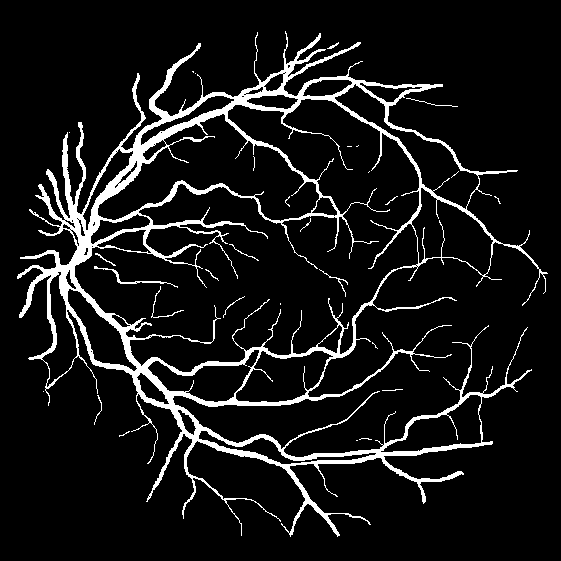

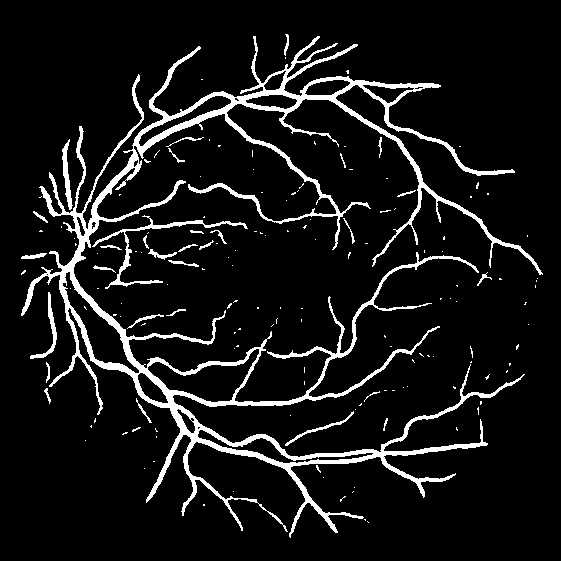

{'iou': tensor(0.6013), 'f1': tensor(0.7498), 'prec': tensor(0.8382), 'rec': tensor(0.6898)}


In [9]:
# Test model
test_filename_filter = partial(filename_filter, test=True)
    
test_ds = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map=name_2_label_map, filename_filter=test_filename_filter, 
                                img_opener=img_opener_partial, label_opener=label_opener_partial, 
                                transforms=transform_funcs)

dataset.check_dataset()
test_dl = torch_dataloader.DataLoader(test_ds, batch_size=1, shuffle=False)

accs = learner.test(test_dl)

# Show predictions
xb, yb = test_ds[0]
bin_pred, _ = learner.pred(xb.unsqueeze(0), yb.unsqueeze(0), return_classes=True)


img_util.show(transforms.TransfToPil()(yb.squeeze().to(torch.uint8)), True)
img_util.show(transforms.TransfToPil()(bin_pred[0]), True)

print(accs)

In [18]:
iou = partial(perf_funcs.get_prfa, meas='iou')
pv = img_util.PerfVisualizer(test_ds, model, iou, learner.pred, device=device)

Evaluating images...100%

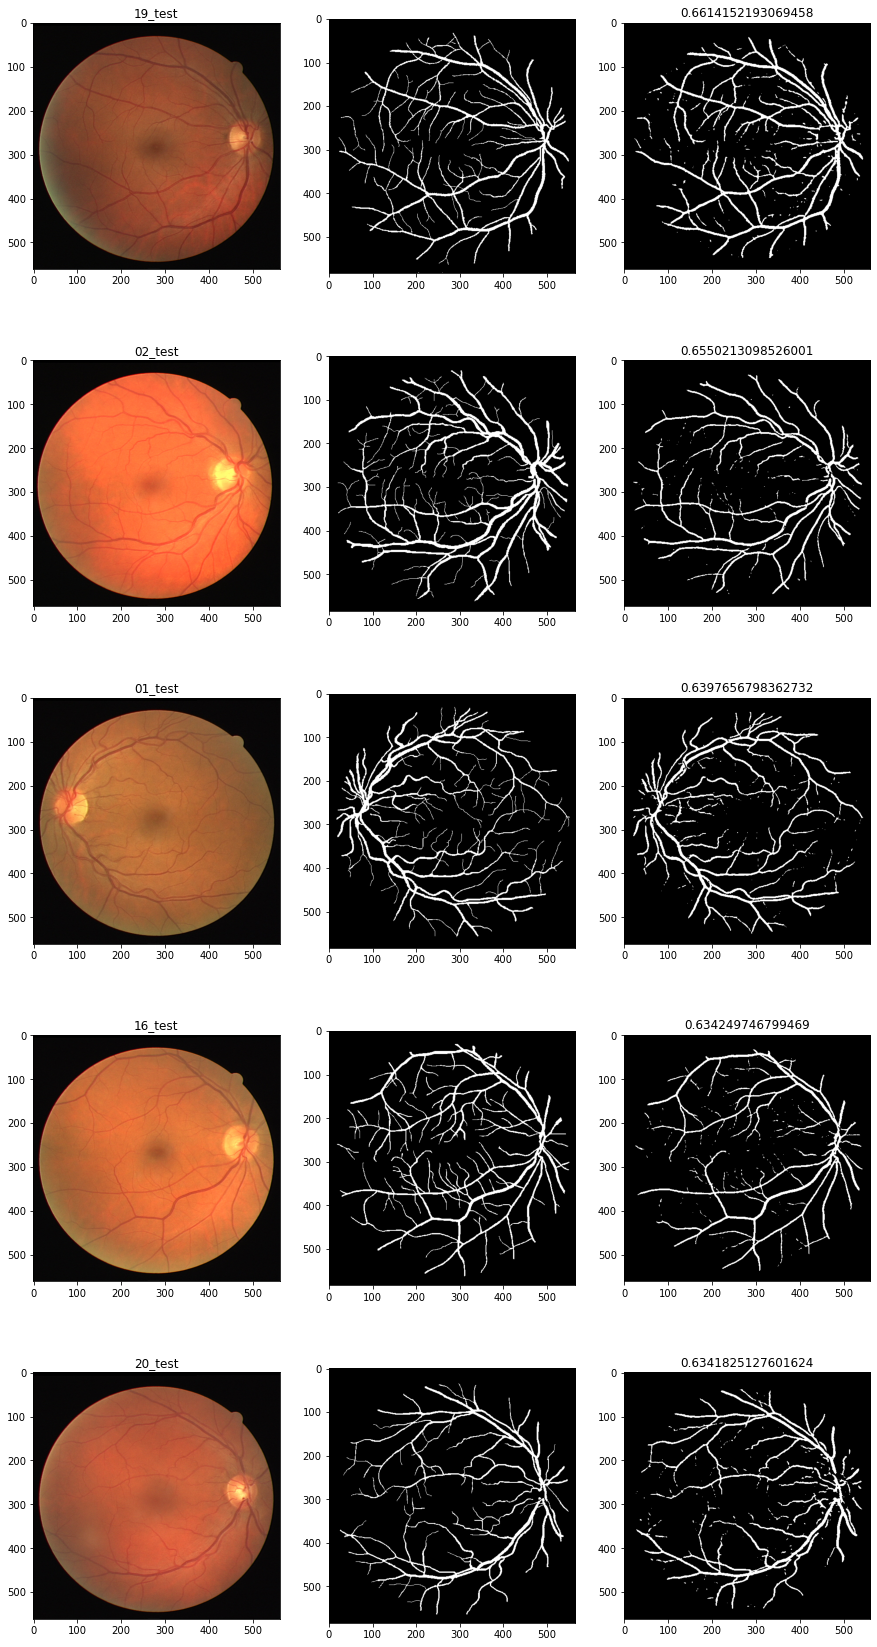

In [21]:
pv.plot_samples(5, 'best', show_original=False)

<IPython.core.display.Javascript object>


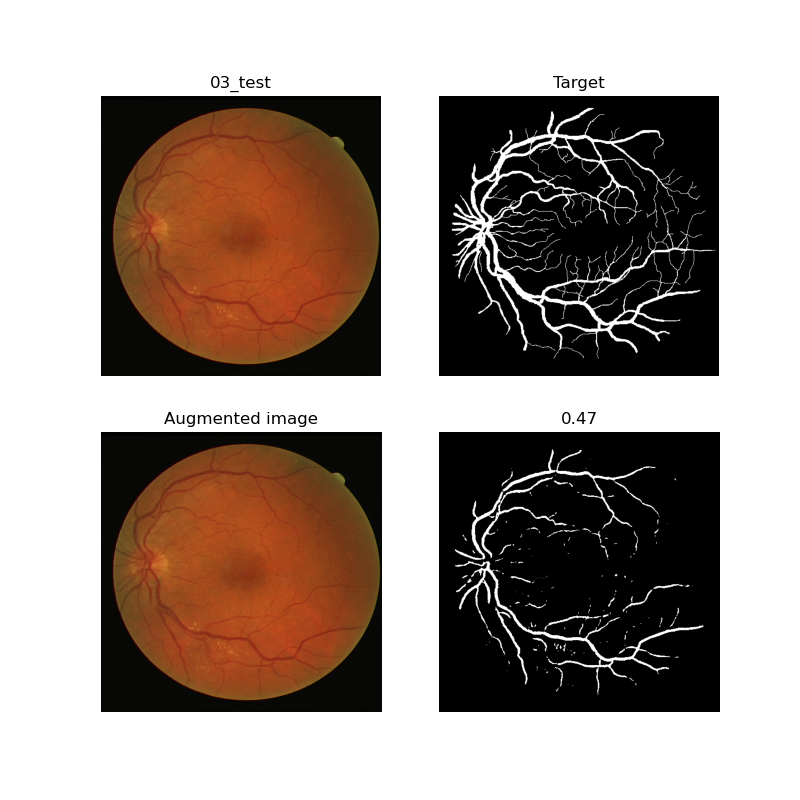

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=19), Output()), _dom_…

In [28]:
%matplotlib notebook
img_util.InteractiveVisualizer(test_ds, model, pv.perf_list)

In [40]:
q = np.array(np.array([2, 3, 4]), copy=False)

In [41]:
q.flags.writeable = False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [47]:
w = q.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [1]:
from igraph import Graph

In [ ]:
Graph.simplify